# Introduction to dataset and data structure

This notebook uses data from the Digital Corpus of Cuneiform Lexical Texts ([DCCLT](http://oracc.org/dcclt)) derived from parsed JSON files. For the JSON output from the Open Richly Annotated Cuneiform Corpus ([ORACC](http://oracc.org)) see the [ORACC Open Data documentation](http://oracc.museum.upenn.edu/doc/opendata/index.html).  

The JSON files are parsed with the notebook [01_grab_json.ipynb](https://github.com/ErinBecker/digital-humanities-phylogenetics/blob/master/scripts/01_grab_json.ipynb). Output from that notebook is saved in the `../data/raw` directory.

This notebook takes an input file from the `../data/raw` directory. The input file for our analyses is [Q39_par.csv](https://github.com/ErinBecker/digital-humanities-phylogenetics/blob/master/data/raw/Q39_par.csv), but we provide other texts in `../data/raw` to use for comparative analyses.

The input file lists Text IDs of Old Babylonian and Middle Babylonian lists of trees and wooden objects currently in [DCCLT](http://oracc.org/dcclt), as well as the composite text of the [Nippur version](http://oracc.org/Q000039). Text IDs consist of a P plus a six-digit number (commonly referred to as P-number) that is recognized by [ORACC](http://oracc.org) and by the Cuneiform Digital Library Initiative ([CDLI](http://cdli.ucla.edu)) and that has become the de-facto standard in Assyriology. [CDLI](http://cdli.ucla.edu) provides metadata (provenience, period, publication, museum number, etc) for each text. Composite text IDs consist of a Q plus a six-digit number (for instance Q000039). Texts that have not (yet) been cataloged in [CDLI](http://cdli.ucla.edu) receive a (temporary) six-digit X number.

The output from this notebook is placed in the directory [data/pass](https://github.com/ErinBecker/digital-humanities-phylogenetics/tree/master/data/pass). The output is a comma-separated file with the following fields: 

| field         | description                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| id_line   	| consists of a text ID (P, Q, or X number) plus a reference number 	|
| label 	| line number: obverse/reverse, column number, line number (e.g. o ii 16')                                                          	|
| lemma      	| Sumerian words in lemmatized form (e.g. lugal[king]N); for unlemmatized words the raw transliteration is taken                                                                                  	|
| base      	| Sumerian words in original spelling, but without morphological prefixes or suffixes   |
| extent | (for missing data): how many lines or columns (restricted vocabulary) are missing|
| scope | (for missing data): what is missing - line, column, face, or surface (restricted vocabulary) |

There are various types of missing data, represented in different ways. A word that is present, but not lemmatized is represented in its transliterated form, followed by [NA]NA (that is: Guideword and part of speech (POS) are both NA). Words that are partly or entirely illegible on the original document are by definition unlemmatized and are handled the same way.

Lines or multiple lines that are missing are indicated in the fields `extent` and `scope`. `Extent` gives the number of missing lines (or missing columns, etc). The restricted vocabulary includes numbers and the words 'n' (unknown), 'beginning', and 'rest'. `Scope` indicates the scope of the missing text: line, column, obverse, etc.

| type         | how represented                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| words with unknown lemmatization| siki-siki[NA]NA |
| illegible words | x[NA]NA |
| known number of missing lines 	|extent: '5' scope: 'line' |
| unknown number of missing lines	|extent: 'n' scope: 'line |
| two missing columns  | extent: '2' scope: 'column'|
  


In [1]:
import pandas as pd
import numpy as np

# Reading in and structuring the data

Choose a file (from the `csv` files in `data/raw`) and create a Dataframe in Pandas. Note that the field `extent` has to be read as string (not float); this is dealt with with the argument `dtype={'extent': object}`. See [stackoverflow](http://stackoverflow.com/questions/13293810/import-pandas-dataframe-column-as-string-not-int).

In [2]:
filename = input('Filename: ')

Filename: Q39_par.csv


In [3]:
file = '../data/raw/' + filename
df = pd.read_csv(file, dtype={'extent': object})

In [4]:
df.head()

,id_text,id_line,label,lemma,base,extent,scope
0,P117395,2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN
1,P117395,3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN
2,P117395,4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN
3,P117404,2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN
4,P117404,3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN


## The `skip` variable

The variable `skip` is used to compute the distance between two lines in the data set. If a line has data (in `label`, `lemma`, and `base`) `skip` = 0. If, however, the original text has 5 missing lines, there will be a separate row, where `skip` is 5. If there is a gap in the text of unknown length, `skip` will be NaN.

The `skip` variable works as follows (simplified data representation):

|`label` | `lemma` | `skip` | `line`
|--------|----------|--------|------|
| o ii 4 | gigir[chariot]N    | 0| 43 |
| o ii 5 | sahargi[dustguard]N gigir[chariot]N | 0| 44 |
| NaN     | NAN     | 5 | 45 |
| o ii 11 | margida[wagon]N | 0| 46 |


The distance between the `margida[wagon]N` line and the `gigir[chariot]N` line is 7 (`line`₂ - `line`₁ + `skip`₁:₂ -1).

The variable `skip` is computed from the [ORACC](http://oracc.org) variables `extent` and `scope`, which are part of the so-called \$-line conventions. These conventions are explained in more detail [here](http://oracc.org/doc/help/editinginatf/primer/structuretutorial). A 'strict' \$-line uses a limited vocabulary to describe the preservation or state of the object on which the text is written. Examples of strict \$-lines are:,
* \$ beginning of column missing
* \$ 7 lines traces

In these examples '7' and 'beginning' are the `extent`; 'column' and 'line' are `scope` ('missing' and 'traces' are `state`. The variable 'state' is ignored here - treating 'missing', 'broken', 'traces', etc. all as absence of data).

If lines are missing the `extent` variable will indicate the number of missing lines or columns. A line with data has `extent` NaN.

The variable `skip` is computed as follows:

* if the line has data (in `label`, `lemma`, and `base`) `skip` = 0
* if `scope` == 'column', or anything other than 'line', `skip` = NaN
* if `extent` is a digit, `skip` is the integer version of that digit
* if `extent` is 'n' or 'beginning' (or anything other than a digit), `skip` = NaN

Because NaN cannot be used in a column of integers, `skip` will become a float.

In [5]:
df.extent = df.extent.fillna('0')
df['skip'] = [int(n) if n.isdigit() else np.NaN for n in df.extent]

The variable `scope` may include 'line', 'column', 'obverse', etc. Only if scope is `line` the variable 'extent' is meaningful (if, say, 2 columns are missing, 'extent' is '2' but should be NaN because we do not know how many lines those 2 columns represent). If `scope` is NaN `extent` is '0' and should remain so. After this operation the column 'scope' can be dropped.

In [6]:
df.skip = [df.skip[i] if df.scope[i] in ['line', np.NaN] else np.NaN for i in range(len(df))] 
df = df.drop(['scope', 'extent'], axis=1)
df.head()

,id_text,id_line,label,lemma,base,skip
0,P117395,2,o 1,ŋešed[key]N,{ŋeš}e₃-a,0.0
1,P117395,3,o 2,pakud[~tree]N,{ŋeš}pa-kud,0.0
2,P117395,4,o 3,raba[clamp]N,{ŋeš}raba,0.0
3,P117404,2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,0.0
4,P117404,3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,0.0


## Create Expressions
A line in a lexical text may contain more than one word. Usually a list is divided into sections by keyword, for instance:

| text                	| translation                      	|
|---------------------	|----------------------------------	|
| {ŋeš}gigir          	| chariot                          	|
| {ŋeš}e₂ gigir       	| chariot cabin                    	|
| {ŋeš}e₂ usan₃ gigir 	| storage box for the chariot whip 	|
| {ŋeš}gaba gigir     	| breastwork of a chariot          	|

In the comparison between different versions of the list the individual words are less interesting than the *entries*, that is: the sequence of words in a single line. In order to look at entries (rather than words), words in an entry are connected by underscores (_).

In [7]:
df['entry'] = df['lemma'].str.replace(' ', '_')
df.head()

,id_text,id_line,label,lemma,base,skip,entry
0,P117395,2,o 1,ŋešed[key]N,{ŋeš}e₃-a,0.0,ŋešed[key]N
1,P117395,3,o 2,pakud[~tree]N,{ŋeš}pa-kud,0.0,pakud[~tree]N
2,P117395,4,o 3,raba[clamp]N,{ŋeš}raba,0.0,raba[clamp]N
3,P117404,2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,0.0,ig[door]N_eren[cedar]N
4,P117404,3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,0.0,ig[door]N_dib[board]N


### Passing data to R

The first step in passing our data from Python to R is converting the Python null value (`NaN`) to the R null value (`NA`). We do this by converting all `NaN` values in character/string columns to the intermediate value `unknown` and all `NaN` values in our numeric `skip` column to the intermediate value `999`.

We will then convert both of these values to `NA` after passing the data to R.

The directory `data/pass` is used for passing data from Python to R and vv.

In [8]:
df.skip = df.skip.fillna(999)
df = df.fillna('unknown')
df.to_csv("../data/pass/" + filename, index=False)

# Dendrogram in Python
experimenting ... Everything above is identical with notebook `02_structure_data.ipynb`.

# Create Documet Term Matrix

In [9]:
texts = df.groupby([df['id_text']]).agg({
        'entry': ' '.join   
        }).reset_index()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer 

In [11]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
dtm = cv.fit_transform(texts['entry'])
dtm_df = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names(), index = texts["id_text"])
text_length =  dtm_df.sum(axis=1)
dtm_df.head(10)

,1/2[na]na_giŋ[unit]n,5/6[na]na_sila[unit]n,a[arm]n_apin[plow]n,a[arm]n_diš[na]na,a[arm]n_gud[ox]n_apin[plow]n,a[arm]n_umbin[wheel]n_margida[cart]n,a[arm]n_ŋešrin[scales]n,ab[cow]n,ab[cow]n_ib[hips]n_gig[sick]v/i,ab[cow]n_mah[mature]v/i,...,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_x[na]na,šuʾa[stool]n_šu[hand]n,šuʾa[stool]n_šuʾi[barber]n
id_text,,,,,,,,,,,,,,,,,,,,,
P117395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P117404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P128345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P225006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P225023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Remove broken/unknown entries
Remove columns that contain unknwon/broken words (with guideword `na` and POS `na`).

In [12]:
entries = list(dtm_df.columns)
entries_no_na = [entry for entry in entries if not '[na]na' in entry]
dtm_no_na_df = dtm_df[entries_no_na]
dtm_no_na_df

,a[arm]n_apin[plow]n,a[arm]n_gud[ox]n_apin[plow]n,a[arm]n_umbin[wheel]n_margida[cart]n,a[arm]n_ŋešrin[scales]n,ab[cow]n,ab[cow]n_ib[hips]n_gig[sick]v/i,ab[cow]n_mah[mature]v/i,ab[cow]n_peš[thick]v/i,ab[cow]n_si[horn]n_ŋal[be]v/i,ab[cow]n_suhub[~oxen]n,...,šuʾa[stool]n_ašgab[leatherworker]n,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_šu[hand]n,šuʾa[stool]n_šuʾi[barber]n
id_text,,,,,,,,,,,,,,,,,,,,,
P117395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P117404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P128345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P225006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P225023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Minimum text length
Remove documents that are too short.

In [13]:
min = 10
keep = dtm_no_na_df.loc[dtm_no_na_df.sum(axis = 1) > min ]

In [14]:
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as hcl
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [15]:
keep

,a[arm]n_apin[plow]n,a[arm]n_gud[ox]n_apin[plow]n,a[arm]n_umbin[wheel]n_margida[cart]n,a[arm]n_ŋešrin[scales]n,ab[cow]n,ab[cow]n_ib[hips]n_gig[sick]v/i,ab[cow]n_mah[mature]v/i,ab[cow]n_peš[thick]v/i,ab[cow]n_si[horn]n_ŋal[be]v/i,ab[cow]n_suhub[~oxen]n,...,šuʾa[stool]n_ašgab[leatherworker]n,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_šu[hand]n,šuʾa[stool]n_šuʾi[barber]n
id_text,,,,,,,,,,,,,,,,,,,,,
P228096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P228105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P228196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P229426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P235262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P247864,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
P250361,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P250363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P250364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


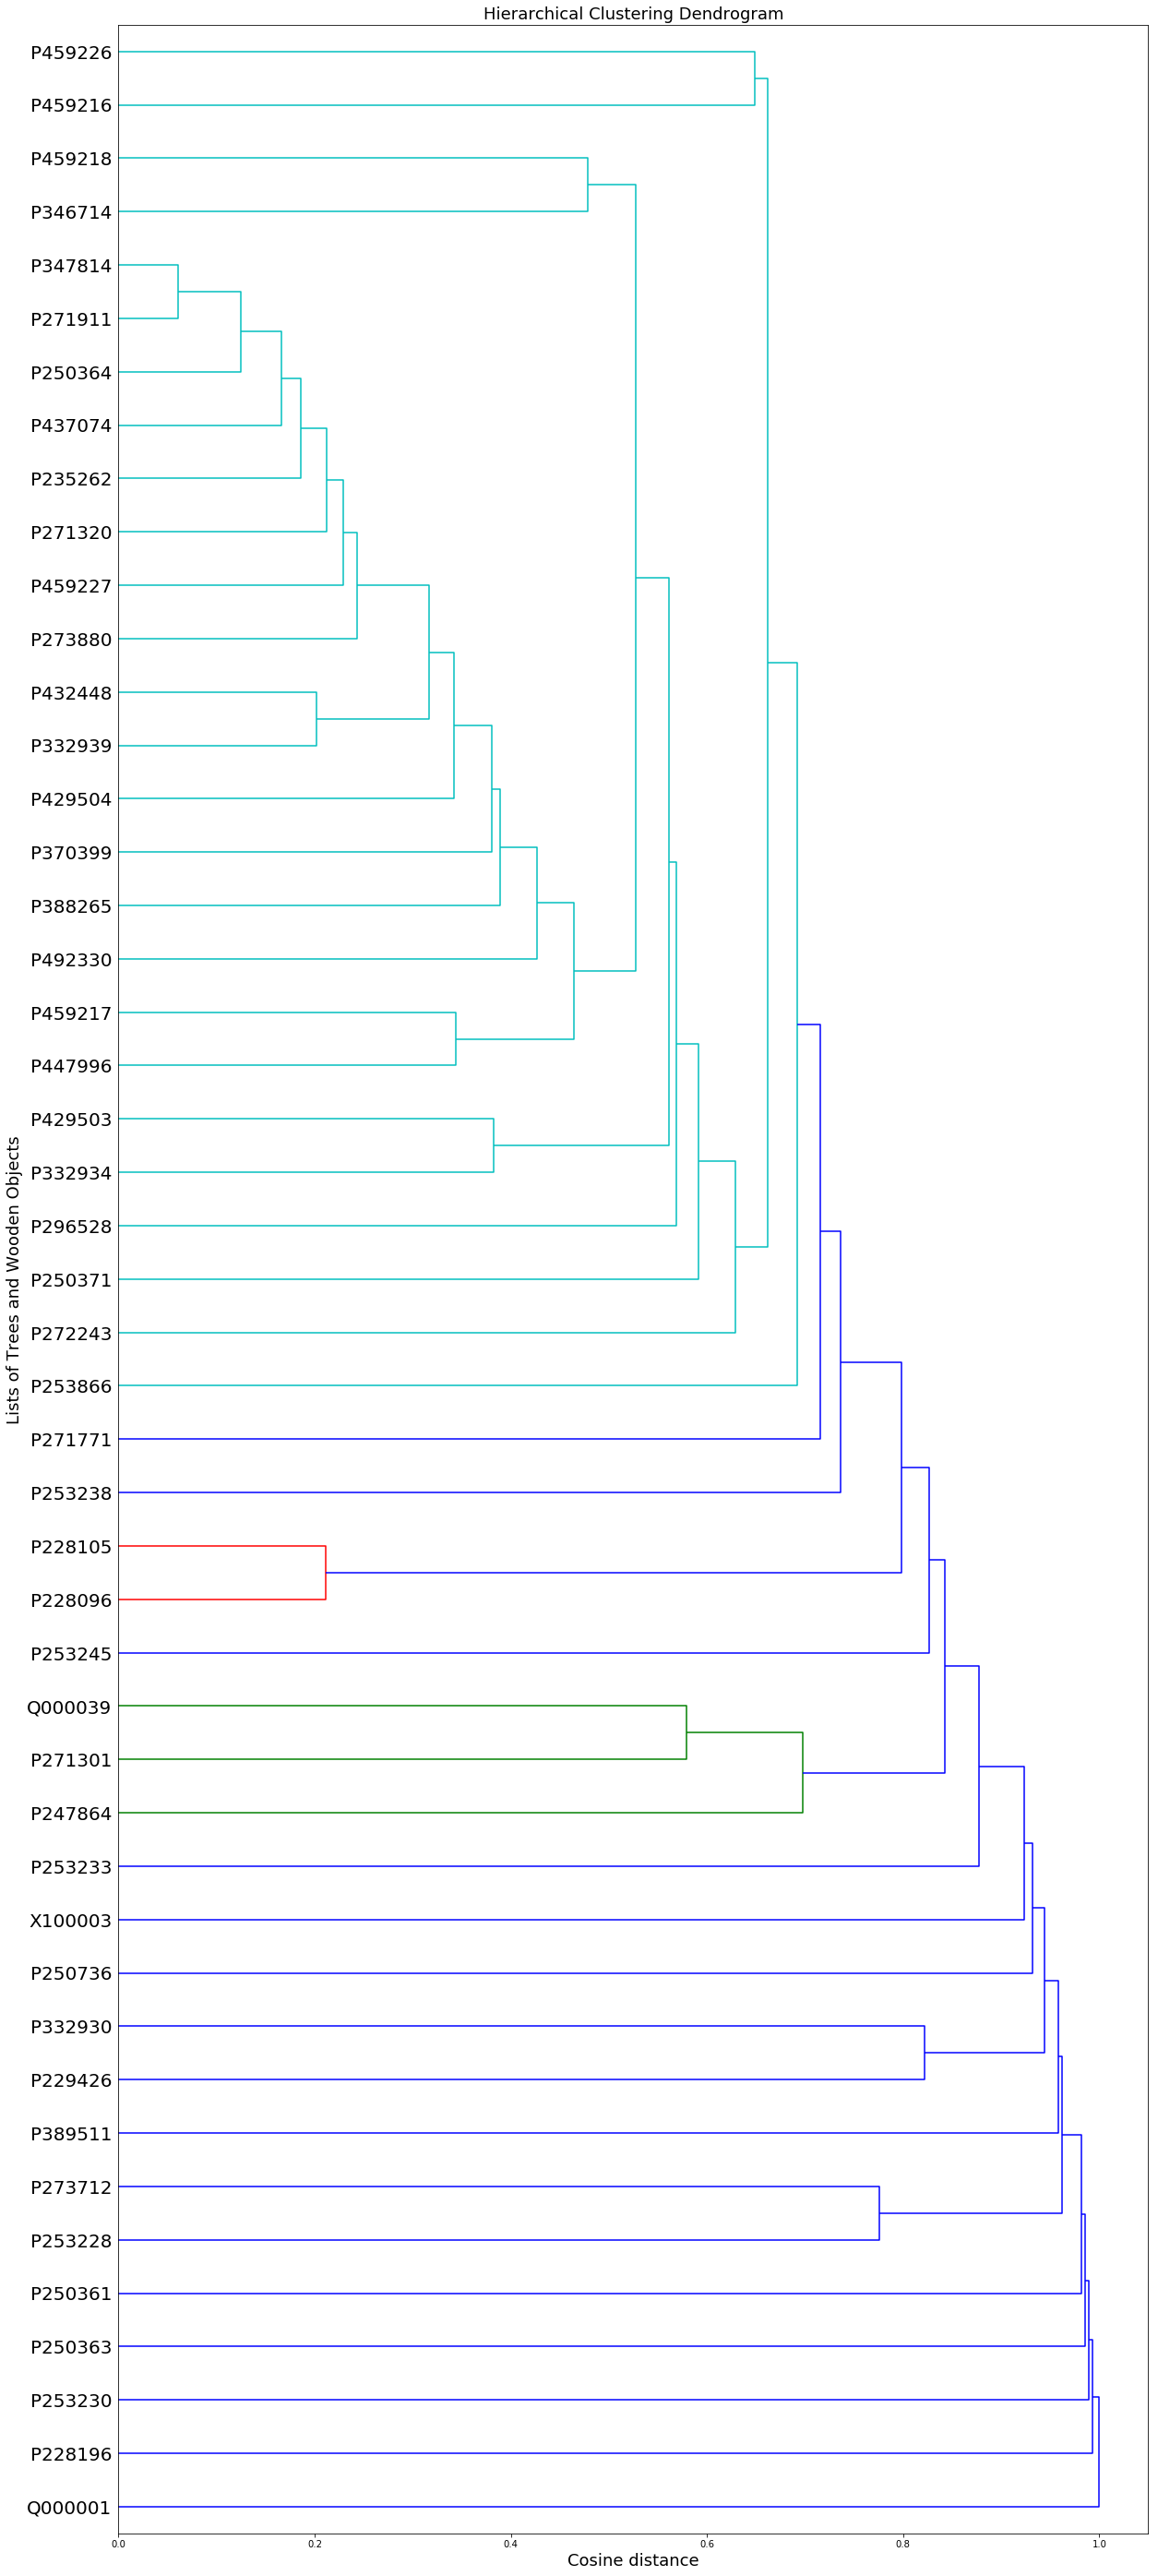

0.95608235518470719

In [16]:
Z = hcl.linkage(keep, 'average', 'cosine')
plt.figure(figsize=(20, 50))
plt.title('Hierarchical Clustering Dendrogram', fontsize = 18)
plt.xlabel('Cosine distance', fontsize=18)
plt.ylabel('Lists of Trees and Wooden Objects', fontsize = 18)
hcl.dendrogram(
        Z,
        labels = keep.index,
        orientation = 'right',
#        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=20.,  # font size for the x axis labels
    )
plt.show()
c, coph_dists = hcl.cophenet(Z, pdist(keep, 'cosine'))
c

In [17]:
Z

array([[ 20.     ,  29.     ,   0.06081,   2.     ],
       [  8.     ,  47.     ,   0.12485,   3.     ],
       [ 36.     ,  48.     ,   0.16599,   4.     ],
       [  4.     ,  49.     ,   0.1863 ,   5.     ],
       [ 27.     ,  35.     ,   0.20184,   2.     ],
       [  0.     ,   1.     ,   0.21119,   2.     ],
       [ 18.     ,  50.     ,   0.21184,   6.     ],
       [ 42.     ,  53.     ,   0.22913,   7.     ],
       [ 23.     ,  54.     ,   0.24365,   8.     ],
       [ 51.     ,  55.     ,   0.31703,  10.     ],
       [ 34.     ,  56.     ,   0.34218,  11.     ],
       [ 37.     ,  39.     ,   0.34417,   2.     ],
       [ 30.     ,  57.     ,   0.38048,  12.     ],
       [ 26.     ,  33.     ,   0.38221,   2.     ],
       [ 31.     ,  59.     ,   0.38883,  13.     ],
       [ 43.     ,  61.     ,   0.42675,  14.     ],
       [ 58.     ,  62.     ,   0.46432,  16.     ],
       [ 28.     ,  40.     ,   0.47869,   2.     ],
       [ 63.     ,  64.     ,   0.52736,  18. 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(keep)
diff = 1 - similarities
diff

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
plotly.tools.set_credentials_file(username='veldhuis', api_key='MV1kKiFmjn7ePbebyvzU')

In [ ]:
labels = keep.index
dcclt_link = '<a href="http://oracc.org/dcclt/'
labels = [dcclt_link + label + '">' + label + '</a>' for label in labels]

In [ ]:
from scipy.cluster.hierarchy import linkage
figure = ff.create_dendrogram(
    keep, orientation='left', labels=labels,
    linkagefun=lambda x: linkage(keep, 'average', metric='cosine')
)
figure['layout'].update({'width':800, 'height':800, 
                         'title': "linkage = average<br>data from <a href='http://oracc.org/dcclt'>dcclt</a>"}, 
                        xaxis={'title':'cosine distance'}, yaxis={'title':'text IDs'})
py.iplot(figure, filename='dendrogram_with_labels')